In [77]:
# Dictionary for converting SMILES characters to numbers
smiles_dict = {
    "#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, ".": 2,
    "1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, "7": 38, "6": 6,
    "9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43,
    "D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13,
    "O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51,
    "V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "c": 56,
    "b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24, "m": 60,
    "l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28, "y": 64,
    " ": 65, ":": 66, ",": 67, "p": 68, "j": 69, "*": 70
    }

def label_smiles(line, MAX_SMI_LEN, smi_ch_ind):
    X = np.zeros(MAX_SMI_LEN, dtype=int)
    for i, ch in enumerate(line[:MAX_SMI_LEN]):
        if ch in smi_ch_ind:
            X[i] = smi_ch_ind[ch]
    return X

In [60]:
def train_deep_cbn(dataset_path, target_col, smiles_col, n_epochs = 100):
    import os
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    import keras
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    from tensorflow.keras import optimizers, layers, metrics
    from tensorflow.keras.layers import (
        Input, Dense, Dropout, BatchNormalization, Conv1D,
        GlobalAveragePooling1D, Lambda, Activation, Concatenate
    )
    from tensorflow.keras.models import Model
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

    # === Load Dataset ===
    data = pd.read_csv(dataset_path)
    smiles = data[smiles_col]
    labels = data[target_col]
    
    # Dictionary for converting SMILES characters to numbers
    smiles_dict = {
    "#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, ".": 2,
    "1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, "7": 38, "6": 6,
    "9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43,
    "D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13,
    "O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51,
    "V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "c": 56,
    "b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24, "m": 60,
    "l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28, "y": 64,
    " ": 65, ":": 66, ",": 67, "p": 68, "j": 69, "*": 70
    }

    def label_smiles(line, MAX_SMI_LEN, smi_ch_ind):
        X = np.zeros(MAX_SMI_LEN, dtype=int)
        for i, ch in enumerate(line[:MAX_SMI_LEN]):
            if ch != '\n' and ch in smi_ch_ind:
                X[i] = smi_ch_ind[ch]
        return X

    XD = np.array([label_smiles(str(smi), 100, smiles_dict) for smi in smiles])
    labels = labels.values

    # Convert to categorical
    XD = to_categorical(XD, num_classes=71)

    #### Phase 1 ####

    # Feature model definition (unchanged)
    XDinput = Input(shape=(100, 71), name='XDinput')
    encode_smiles = Conv1D(filters=64, kernel_size=2, activation='relu', padding='valid', strides=1)(XDinput)  # (99,64)
    encode_smiles = Conv1D(filters=64, kernel_size=4, activation='relu', padding='valid', strides=1)(encode_smiles)  # (96,64)
    encode_smiles = Conv1D(filters=128, kernel_size=4, activation='relu', padding='valid', strides=1)(encode_smiles)  # (93,128)
    model_feature = Model(inputs=XDinput, outputs=encode_smiles, name='model_feature')
    model_feature.summary()


    # Prediction model definition
    input_extracted_feature = Input(shape=(93, 128))
    FC1 = Dense(512, activation='relu')(input_extracted_feature)
    FC1 = BatchNormalization()(FC1)
    FC2 = Dropout(0.1)(FC1)
    FC3 = Dense(256, activation='relu')(FC2)
    FC3 = BatchNormalization()(FC3)
    FC4 = Dropout(0.1)(FC3)
    FC5 = Dense(64, activation='relu')(FC4)
    predictions = Dense(2, activation='softmax')(FC5)
    model_pred = Model(inputs=input_extracted_feature, outputs=predictions)
    model_pred.summary()

    # Full model definition with added Pooling layer
    interaction_input = XDinput
    encoded_features = model_feature(interaction_input) # Output: (None, 93, 128)
    predicted_output = model_pred(encoded_features)  # Output: (None, 93, 2)

    # Adding Pooling layer to reduce dimensionality
    pooled_output = GlobalAveragePooling1D()(predicted_output) # Output: (None, 2)
    interactionModel = Model(inputs=interaction_input, outputs=pooled_output, name='interactionModel')
    interactionModel.summary()

    ### BiFormer Block ###
    class DropPath(layers.Layer):
         # Placeholder for DropPath, currently no-op
        def __init__(self, drop_prob=0.):
            super().__init__()
            self.drop_prob = drop_prob
        def call(self, x, training=None):
            if (not training) or self.drop_prob == 0.:
                return x
            keep_prob = 1 - self.drop_prob
            random_tensor = keep_prob
            random_tensor += tf.random.uniform(tf.shape(x), dtype=x.dtype)
            binary_tensor = tf.floor(random_tensor)
            return tf.divide(x, keep_prob) * binary_tensor
        
    # Define custom layers for 1D processing
    class TopkRouting(layers.Layer):
        def __init__(self, qk_dim, topk=16, qk_scale=None, param_routing=False, diff_routing=False):
            super().__init__()
            self.topk = topk
            self.qk_dim = qk_dim
            self.scale = qk_scale if qk_scale is not None else qk_dim**-0.5
            self.diff_routing = diff_routing
            if param_routing:
                self.emb = layers.Dense(qk_dim)
            else:
                self.emb = lambda x: x
            self.routing_act = lambda x, axis: tf.nn.softmax(x, axis=axis)
        def call(self, query, key, training=None):
            if not self.diff_routing:
                query = tf.stop_gradient(query)
                key = tf.stop_gradient(key)
            query_hat = self.emb(query)
            key_hat = self.emb(key)
            attn_logit = tf.einsum('bnc,bqc->bnq', query_hat*self.scale, key_hat)
            topk_attn_logit, topk_index = tf.math.top_k(attn_logit, k=self.topk, sorted=True)
            r_weight = self.routing_act(topk_attn_logit, axis=-1)
            return r_weight, topk_index

    def tf_gather_kv(kv, r_idx):
        n = tf.shape(kv)[0]
        p2 = tf.shape(kv)[1]
        c_kv = tf.shape(kv)[2]
        topk = tf.shape(r_idx)[2]
        batch_idx = tf.reshape(tf.range(n), [n, 1, 1])
        batch_idx = tf.tile(batch_idx, [1, p2, topk])
        p2_idx = tf.reshape(tf.range(p2), [1, p2, 1])
        p2_idx = tf.tile(p2_idx, [n, 1, topk])
        gather_indices = tf.stack([batch_idx, p2_idx, r_idx], axis=-1)
        gathered = tf.gather_nd(kv, gather_indices)
        return gathered

    class KVGather(layers.Layer):
        def __init__(self, mul_weight='none'):
            super().__init__()
            assert mul_weight in ['none', 'soft', 'hard']
            self.mul_weight = mul_weight
        def call(self, r_idx, r_weight, kv, training=None):
            topk_kv = tf_gather_kv(kv, r_idx)
            if self.mul_weight == 'soft':
                r_weight_exp = tf.expand_dims(tf.expand_dims(r_weight, -1), -1)
                topk_kv = topk_kv * r_weight_exp
            return topk_kv

    class QKVLinear(layers.Layer):
        def __init__(self, dim, qk_dim, bias=True):
            super().__init__()
            self.dim = dim
            self.qk_dim = qk_dim
            self.qkv = layers.Dense(qk_dim + qk_dim + dim, use_bias=bias)
        def call(self, x, training=None):
            qkv = self.qkv(x)
            q, kv = tf.split(qkv, [self.qk_dim, self.qk_dim + self.dim], axis=-1)
            return q, kv

    class BiLevelRoutingAttention(layers.Layer):
        def __init__(self, dim, n_win=7, num_heads=8, qk_dim=None, qk_scale=None,
                     kv_per_win=4, kv_downsample_ratio=4, kv_downsample_mode='identity',
                     topk=4, param_attention="qkvo", param_routing=False, diff_routing=False, soft_routing=False,
                     side_dwconv=3, auto_pad=True):
            super().__init__()
            self.dim = dim
            self.n_win = n_win
            self.num_heads = num_heads
            self.qk_dim = qk_dim if qk_dim is not None else dim
            self.scale = qk_scale if qk_scale is not None else self.qk_dim**-0.5
            self.topk = topk
            self.param_routing = param_routing
            self.diff_routing = diff_routing
            self.soft_routing = soft_routing
            self.auto_pad = auto_pad

             # For 1D, we use Conv1D
            if side_dwconv > 0:
                self.lepe = layers.Conv1D(dim, kernel_size=side_dwconv, padding='same', activation='relu')
            else:
                self.lepe = lambda x: tf.zeros_like(x)
            self.router = TopkRouting(qk_dim=self.qk_dim, topk=self.topk, qk_scale=self.scale,
                                      param_routing=self.param_routing, diff_routing=self.diff_routing)
            mul_weight = 'none'
            if self.soft_routing:
                mul_weight = 'soft'
            self.kv_gather = KVGather(mul_weight=mul_weight)
            if param_attention in ['qkvo', 'qkv']:
                self.qkv = QKVLinear(self.dim, self.qk_dim)
                if param_attention == 'qkvo':
                    self.wo = layers.Dense(self.dim)
                else:
                    self.wo = lambda x: x
            else:
                raise ValueError("Unsupported param_attention mode")
            self.attn_act = lambda x: tf.nn.softmax(x, axis=-1)
            self.kv_down = lambda x: x # identity for simplicity

        def call(self, x, training=None, ret_attn_mask=False):
            # Implementing full attention can be complex, so here we only keep the general structure
            if ret_attn_mask:
                return x, None, None, None
            else:
                return x

    class Attention(layers.Layer):
        def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
            super().__init__()
            self.num_heads = num_heads
            head_dim = dim // num_heads
            self.scale = qk_scale if qk_scale is not None else head_dim**-0.5
        def call(self, x, training=None):
            return x

    class AttentionLePE(layers.Layer):
        def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., side_dwconv=3):
            super().__init__()
            self.num_heads = num_heads
            head_dim = dim // num_heads
            self.scale = qk_scale if qk_scale is not None else head_dim**-0.5
            self.side_dwconv = layers.Conv1D(dim, kernel_size=side_dwconv, padding='same', activation='relu')
        def call(self, x, training=None):
            return x

    class Mlp(layers.Layer):
        def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
            super().__init__()
            out_features = out_features or in_features
            hidden_features = hidden_features or in_features
            self.net = keras.Sequential([
                layers.Dense(hidden_features),
                layers.Activation('gelu'),
                layers.Dropout(rate=drop),
                layers.Dense(out_features),
                layers.Dropout(rate=drop)
            ])
        def call(self, x, training=True):
            return self.net(x, training=training)

    class Block(layers.Layer):
        def __init__(self, dim, drop_path=0.1, layer_scale_init_value=-1,
                     num_heads=8, n_win=7, qk_dim=128, qk_scale=None,
                     kv_per_win=8, kv_downsample_ratio=1, kv_downsample_mode='identity',
                     topk=8, param_attention="qkvo", param_routing=True, diff_routing=False, soft_routing=True,
                     mlp_ratio=4, mlp_dwconv=False, side_dwconv=5, before_attn_dwconv=3, pre_norm=True, auto_pad=True):
            super().__init__()
            qk_dim = qk_dim or dim

            # For 1D, we use Conv1D
            if before_attn_dwconv > 0:
                self.pos_embed = layers.Conv1D(dim, kernel_size=before_attn_dwconv, padding='same', activation='relu')
            else:
                self.pos_embed = lambda x: tf.zeros_like(x)
            self.norm1 = layers.LayerNormalization(epsilon=1e-6)
            if topk > 0:
                self.attn = BiLevelRoutingAttention(dim=dim, num_heads=num_heads, n_win=n_win, qk_dim=qk_dim,
                                                   qk_scale=qk_scale, kv_per_win=kv_per_win, kv_downsample_ratio=kv_downsample_ratio,
                                                   kv_downsample_mode=kv_downsample_mode, topk=topk, param_attention=param_attention,
                                                   param_routing=param_routing, diff_routing=diff_routing, soft_routing=soft_routing,
                                                   side_dwconv=side_dwconv, auto_pad=auto_pad)
            elif topk == -1:
                self.attn = Attention(dim=dim, num_heads=num_heads, qk_scale=qk_scale)
            elif topk == -2:
                self.attn = AttentionLePE(dim=dim, num_heads=num_heads, qk_scale=qk_scale, side_dwconv=side_dwconv)
            else:
                 # Pseudo attention
                self.attn = keras.Sequential([
                    layers.Dense(dim),
                    layers.Conv1D(dim, kernel_size=5, padding='same', activation='relu'),
                    layers.Dense(dim)
                ])
            self.norm2 = layers.LayerNormalization(epsilon=1e-6)
            mlp_hidden_dim = int(mlp_ratio * dim)
            mlp_layers = [layers.Dense(mlp_hidden_dim)]
            if mlp_dwconv:
                mlp_layers.append(layers.Conv1D(mlp_hidden_dim, kernel_size=3, padding='same', activation='relu'))
            mlp_layers.append(layers.Activation('gelu'))
            mlp_layers.append(layers.Dense(dim))
            mlp_layers.insert(1, layers.Dropout(0.2))
            mlp_layers.append(layers.Dropout(0.2))
            self.mlp = keras.Sequential(mlp_layers)
            self.drop_path = DropPath(drop_path) if drop_path > 0. else layers.Lambda(lambda x: x)
            if layer_scale_init_value > 0:
                self.use_layer_scale = True
                self.gamma1 = self.add_weight(shape=(dim,), initializer=tf.keras.initializers.Constant(layer_scale_init_value), trainable=True)
                self.gamma2 = self.add_weight(shape=(dim,), initializer=tf.keras.initializers.Constant(layer_scale_init_value), trainable=True)
            else:
                self.use_layer_scale = False

        def call(self, x, training=None):
            input_x = x
            x = self.pos_embed(x) # Add positional embedding
            x = self.norm1(x)
            attn = self.attn(x, training=training)
            if self.use_layer_scale:
                attn = self.gamma1 * attn
            x = input_x + self.drop_path(attn, training=training)
            input_x = x
            x = self.norm2(x)
            mlp_output = self.mlp(x, training=training)
            if self.use_layer_scale:
                mlp_output = self.gamma2 * mlp_output
            x = input_x + self.drop_path(mlp_output, training=training)
            return x

    ### Phase 2 ###
    # Parameter settings for the block
    dim = 128 # Adjusted from 192 to 128
    num_heads = 8

    # Create Phase 2 model
    input_phaz2 = Input(shape=(93, 128)) # Input shape is (batch_size, sequence_length, embedding_dim)
    
    # processed_input = model_feature(input_phaz2)
    processed_input = input_phaz2

    # Define transformer blocks
    transformer_block1 = Block(dim=dim, drop_path=0.2, num_heads=num_heads, topk=16, mlp_ratio=3)
    transformer_block2 = Block(dim=dim, drop_path=0.2, num_heads=num_heads, topk=16, mlp_ratio=3)

    # Apply the first transformer block
    transformer_output1 = transformer_block1(processed_input)

    # Compute the norm of the output along the last axis (preserving dimensions)
    transformer_output1 = Lambda(lambda x: tf.norm(x, axis=-1, keepdims=True))(transformer_output1)

    # Apply the second transformer block
    transformer_output2 = transformer_block2(processed_input)

    # Compute the norm of the output along the last axis (preserving dimensions)
    transformer_output2 = Lambda(lambda x: tf.norm(x, axis=-1, keepdims=True))(transformer_output2)

    # Combine the outputs of both transformer blocks along the last axis
    combined_outputs = Concatenate(axis=-1)([transformer_output1, transformer_output2])

    # Apply global average pooling to reduce the output to (batch_size, 2)
    pooled_outputs = GlobalAveragePooling1D()(combined_outputs)

    # Compute the difference between the two pooled outputs and reshape to (batch_size, 1)
    difference = Lambda(lambda x: tf.expand_dims(x[:, 0] - x[:, 1], axis=-1), name='difference')(pooled_outputs)

    # Apply sigmoid activation to normalize the output to the range [0, 1]
    condition_2 = Activation('sigmoid', name='activation_11')(difference)

    # Freeze the `model_feature` layers to prevent them from being trained
    model_feature.trainable = False

    # Define the complete model
    model_phaz2 = Model(inputs=input_phaz2, outputs=condition_2)
    model_phaz2.summary()

    ### Phase 3 ####
    # Define new transformer blocks
    new_transformer_block = Block(dim=dim, drop_path=0.2, num_heads=num_heads, topk=16, mlp_ratio=3)
    new_transformer_block2 = Block(dim=dim, drop_path=0.2, num_heads=num_heads, topk=16, mlp_ratio=3)

    # Input for Phase 3
    XDinput_phaz3 = Input(shape=(100, 71))

    # Pass input through the feature extraction model
    model_feature_output = model_feature(XDinput_phaz3)

    # Transformer blocks processing
    transformer_output1_phaz3 = new_transformer_block(model_feature_output)
    # Compute the norm along the last axis, retaining dimensions
    transformer_output1_phaz3 = Lambda(lambda x: tf.norm(x, axis=-1, keepdims=True))(transformer_output1_phaz3)

    # Compute the norm along the last axis, retaining dimensions
    transformer_output2_phaz3 = new_transformer_block2(model_feature_output)

    # Compute the norm along the last axis, retaining dimensions
    transformer_output2_phaz3 = Lambda(lambda x: tf.norm(x, axis=-1, keepdims=True))(transformer_output2_phaz3)

    # Combine the outputs of both transformer blocks
    concatenated_phaz3 = Concatenate(axis=-1)([transformer_output1_phaz3, transformer_output2_phaz3])

    # Freeze the weights of feature extractor and transformer blocks
    model_feature.trainable = False
    new_transformer_block.trainable = False
    new_transformer_block2.trainable = False

    # Apply global average pooling to reduce the dimensions to (batch_size, 2)
    pooled_phaz3 = GlobalAveragePooling1D()(concatenated_phaz3)

    # Fully connected layers
    FC1_phaz3 = Dense(512, activation='relu')(pooled_phaz3)
    FC1_phaz3 = BatchNormalization()(FC1_phaz3)
    FC2_phaz3 = Dropout(0.1)(FC1_phaz3)
    FC3_phaz3 = Dense(256, activation='relu')(FC2_phaz3)
    FC3_phaz3 = BatchNormalization()(FC3_phaz3)
    FC4_phaz3 = Dropout(0.1)(FC3_phaz3)
    FC5_phaz3 = Dense(64, activation='relu')(FC4_phaz3)

    # Final prediction layer with softmax activation
    predictions_phaz3 = Dense(2, activation='softmax')(FC5_phaz3)

    # Define the complete model for Phase 3
    model_phaz3 = Model(inputs=XDinput_phaz3, outputs=predictions_phaz3)

    # Model summary
    model_phaz3.summary()
    
    # Metrics for binary classification tasks
    METRICS_BINARY = [
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
    ]

    # Metrics for categorical (multi-class) classification tasks
    METRICS_CATEGORICAL = [
        metrics.CategoricalAccuracy(name='accuracy'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc'),
        metrics.F1Score(average='macro', name='f1_score')
    ]


    ###### Train and Validation ##### 
    # === Data Preparation ===
    XD_np = np.array(XD)
    labels_np = np.array(labels)
    index = np.where(~np.isnan(labels_np))
    labels_np, XD_np = labels_np[index[0]], XD_np[index[0], :]

    # === Train-Test Split ===
    X_train, X_test, y_train, y_test = train_test_split(
        XD_np, labels_np, test_size=0.2, stratify=labels_np, random_state=9
    )

    # Convert labels to categorical format
    y_train_cat = to_categorical(y_train, num_classes=2)
    y_test_cat = to_categorical(y_test, num_classes=2)

    # Compute class weights to handle class imbalance
    class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.ravel()
    )
    class_weight = {
    0: class_weights_array[0],
    1: class_weights_array[1]
    }

    # === Define Optimizer for Interaction Model ===
    opt = optimizers.Adam(learning_rate=0.0001)
    interactionModel.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS_CATEGORICAL)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)

    # === Phase 1: Train Interaction Model ===
    interactionModel.fit(
    X_train, y_train_cat,
    batch_size=256, epochs=n_epochs, class_weight=class_weight,
    callbacks=[early_stopping], verbose=1
    )

    # Evaluate Phase 1 on test data
    test_eval_phase1 = interactionModel.evaluate(X_test, y_test_cat, verbose=1)

    # === Feature Extraction ===
    feature_train = model_feature.predict(X_train)
    feature_test = model_feature.predict(X_test)

    # === Phase 2: Train Model Phase 2 ===
    opt_phaz2 = optimizers.Adam(learning_rate=0.001)
    model_phaz2.compile(optimizer=opt_phaz2, loss="binary_crossentropy", metrics=METRICS_BINARY)
    model_phaz2.fit(
    feature_train, y_train,
    batch_size=256, epochs=n_epochs,class_weight=class_weight,
    callbacks=[early_stopping], verbose=1
    )

    # === Freeze Transformer Blocks ===
    new_transformer_block.set_weights(transformer_block1.get_weights())
    new_transformer_block2.set_weights(transformer_block2.get_weights())  # Corrected as per your comment

    # === Phase 3: Train Model Phase 3 ===
    opt_phaz3 = optimizers.Adam(learning_rate=0.0001)
    model_phaz3.compile(optimizer=opt_phaz3, loss="categorical_crossentropy", metrics=METRICS_CATEGORICAL)

    model_phaz3.fit(
        X_train, y_train_cat,
        batch_size=256, epochs=n_epochs,class_weight=class_weight,
        callbacks=[early_stopping], verbose=1
    )

    # Evaluate Phase 3 on both training and testing data
    train_eval_phase3 = model_phaz3.evaluate(X_train, y_train_cat, verbose=1)
    test_eval_phase3 = model_phaz3.evaluate(X_test, y_test_cat, verbose=1)

    # === Function to Format Results ===
    def format_results(phase1_result, phase3_train_result, phase3_test_result):
            # Define Metric Names
        phase1_metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score']
        phase3_metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score']

        # Create DataFrames
        phase1_test_df = pd.DataFrame([phase1_result], columns=phase1_metrics)
        phase3_train_df = pd.DataFrame([phase3_train_result], columns=phase3_metrics)
        phase3_test_df = pd.DataFrame([test_eval_phase3], columns=phase3_metrics)

        # Display the Results
        print("\n=== Phase 1: Test Evaluation Results ===")
        print(phase1_test_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

        print("\n=== Phase 3: Train Evaluation Results ===")
        print(phase3_train_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

        print("\n=== Phase 3: Test Evaluation Results ===")
        print(phase3_test_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


    # === Display Results ===
    format_results(test_eval_phase1, train_eval_phase3, test_eval_phase3)

    return model_phaz3, train_eval_phase3, test_eval_phase3, X_test, y_test_cat


# Run on Target Data

In [56]:
model_phaz3, train_eval_phase3, test_eval_phase3, X_test, y_test_cat = train_deep_cbn(dataset_path = '../Data/tox21.csv', target_col = 'NR-PPAR-gamma', smiles_col= 'smiles', n_epochs = 100)

Model: "model_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 99, 64)         │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 96, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 93, 128)        │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,496 (228.50 KB)

 Trainable params: 58,496 (228.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 93, 512)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 93, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 93, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 93, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 93, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 93, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 93, 2)          │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,026 (847.76 KB)

 Trainable params: 215,490 (841.76 KB)

 Non-trainable params: 1,536 (6.00 KB)

c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_20', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_21', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Prog

Epoch 1/10
15/21 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.7355 - auc: 0.7990 - f1_score: 0.4312 - loss: 0.7345 - precision: 0.7355 - recall: 0.7355

KeyboardInterrupt: 

# Performance

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


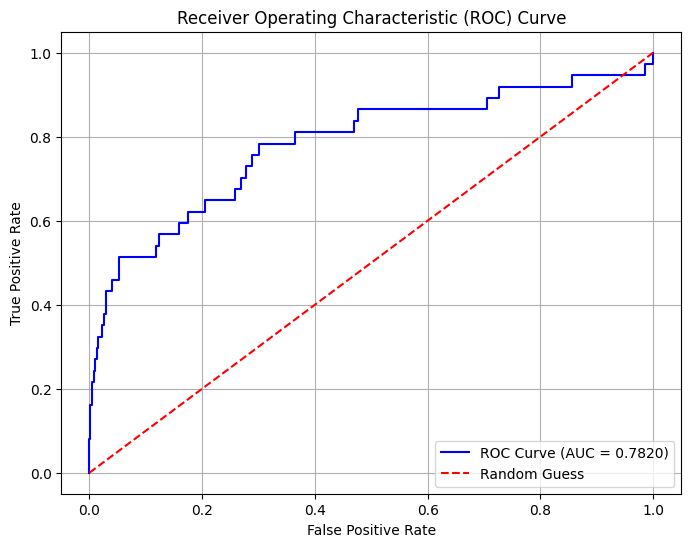

ROC-AUC Score: 0.7820


In [52]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

#function to calculate ROC_AUC

def calculate_roc_auc(model, X_test, y_test_cat):
    y_test = np.argmax(y_test_cat, axis=1)  # Convert one-hot-encoded labels to single-label format

    # Get predicted probabilities for the positive class
    y_pred_proba = model.predict(X_test)

    # Check if there are multiple output classes
    if y_pred_proba.shape[1] > 1:
        # Use probabilities of the positive class only
        y_pred_proba = y_pred_proba[:, 1]

    # Compute ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Compute ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return roc_auc

# Example usage:
roc_auc = calculate_roc_auc(model_phaz3, X_test, y_test_cat)
print(f"ROC-AUC Score: {roc_auc:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test_cat, class_names=None):
    # Convert one-hot encoded labels to single-label format
    y_test = np.argmax(y_test_cat, axis=1)

    # Predict the class probabilities
    y_pred_proba = model.predict(X_test)

    # Get the predicted class labels
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a plot for the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')  # Use '.2f' for floats
    plt.title("Normalized Confusion Matrix")
    plt.show()

    # Print the raw confusion matrix (optional)
    print("Raw Confusion Matrix:")
    print(cm)

    # Print the normalized confusion matrix (optional)
    print("\nNormalized Confusion Matrix:")
    print(cm_normalized)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


<Figure size 800x600 with 0 Axes>

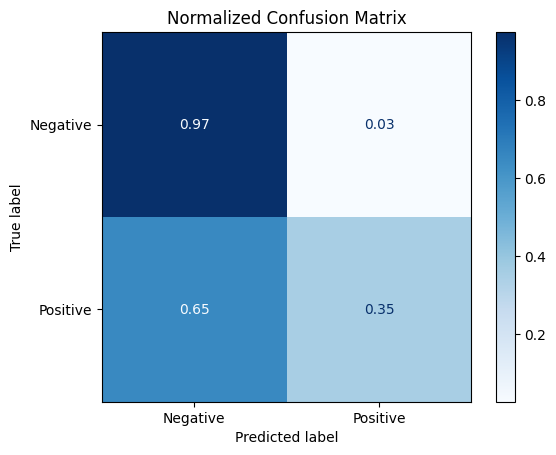

Raw Confusion Matrix:
[[1220   33]
 [  24   13]]

Normalized Confusion Matrix:
[[0.97366321 0.02633679]
 [0.64864865 0.35135135]]


In [ ]:
class_names = ['Negative', 'Positive']

# Call the function
plot_confusion_matrix(model_phaz3, X_test, y_test_cat, class_names=class_names)


# Batch mode

In [67]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def process_multiple_targets(dataset_path, target_cols, smiles_col, n_epochs):
    """
    Train a model for each target column in a dataset, generate confusion matrices,
    and save the results into a unified dataset.

    Args:
        dataset_path (str): Path to the dataset (CSV file).
        target_cols (list): List of target columns to train and evaluate models on.
        smiles_col (str): Name of the column containing SMILES strings.
        n_epochs (int): Number of epochs to train the model.

    Returns:
        pd.DataFrame: Dataframe containing results for all target columns.
        dict: Dictionary containing the trained models for each target column.
    """
    # Initialize a list to store results for each target column
    all_results = []
    
    # Initialize a dictionary to store models for each target column
    models_dict = {}

    for target_col in target_cols:
        print(f"Processing target column: {target_col}")

        # Train the model for the current target column
        model, train_eval, test_eval, X_test, y_test_cat = train_deep_cbn(
            dataset_path=dataset_path,
            target_col=target_col,
            smiles_col=smiles_col,
            n_epochs=n_epochs
        )

        # Save the trained model into the dictionary
        models_dict[target_col] = model

        # Convert one-hot encoded labels back to single-label format
        y_test = np.argmax(y_test_cat, axis=1)

        # Predict probabilities for the test set
        y_pred_proba = model.predict(X_test)

        # Get predicted class labels
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Compute confusion matrix for the current target column
        cm = confusion_matrix(y_test, y_pred)

        # Normalize the confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create a dictionary to store results for the current target column
        results_dict = {
            'target_col': target_col,
            'train_loss': train_eval[0],
            'train_accuracy': train_eval[1],
            'test_loss': test_eval[0],
            'test_accuracy': test_eval[1],
            'confusion_matrix': cm.tolist(),  # Save as a list for serialization
            'confusion_matrix_normalized': cm_normalized.tolist()  # Save normalized CM
        }

        # Append the results to the list
        all_results.append(results_dict)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(all_results)
        
    return results_df, models_dict


In [68]:
# Target columns to process
target_cols = ['NR-PPAR-gamma', 'NR-AhR', 'SR-p53']
dataset_path = '../Data/tox21.csv'
smiles_col = 'smiles'
n_epochs = 50

# Call the function
results_df, models_dict = process_multiple_targets(dataset_path, target_cols, smiles_col, n_epochs)

# Display the results dataframe
print(results_df)

# Access a specific model by target column
model_ppar_gamma = models_dict['NR-PPAR-gamma']


Processing target column: NR-PPAR-gamma


Model: "model_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_154 (Conv1D)             │ (None, 99, 64)         │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_155 (Conv1D)             │ (None, 96, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_156 (Conv1D)             │ (None, 93, 128)        │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,496 (228.50 KB)

 Trainable params: 58,496 (228.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_98 (InputLayer)     │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_392 (Dense)               │ (None, 93, 512)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 93, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 93, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 93, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 93, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 93, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 93, 2)          │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,026 (847.76 KB)

 Trainable params: 215,490 (841.76 KB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "interactionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model_feature (Functional)      │ (None, 93, 128)        │        58,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_98 (Functional)      │ (None, 93, 2)          │       217,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_42     │ (None, 2)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,522 (1.05 MB)

 Trainable params: 273,986 (1.05 MB)

 Non-trainable params: 1,536 (6.00 KB)

c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_56', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_57', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_99      │ (None, 93, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_56 (Block)    │ (None, 93, 128)   │    148,608 │ input_layer_99[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_57 (Block)    │ (None, 93, 128)   │    148,608 │ input_layer_99[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_56 (Lambda)  │ (None, 93, 1)     │          0 │ block_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_57 (Lambda)  │ (None, 93, 1)     │          0 │ block_57[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 93, 2)     │          0 │ lambda_56[0][0],  │
│ (Concatenate)       │                   │            │ lambda_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2)         │          0 │ concatenate_28[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ difference (Lambda) │ (None, 1)         │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 1)         │          0 │ difference[0][0]  │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 297,216 (1.13 MB)

 Trainable params: 297,216 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_58', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_59', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_104"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_102     │ (None, 100, 71)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_feature       │ (None, 93, 128)   │     58,496 │ input_layer_102[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_58 (Block)    │ (None, 93, 128)   │    148,608 │ model_feature[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_59 (Block)    │ (None, 93, 128)   │    148,608 │ model_feature[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_58 (Lambda)  │ (None, 93, 1)     │          0 │ block_58[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_59 (Lambda)  │ (None, 93, 1)     │          0 │ block_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_29      │ (None, 93, 2)     │          0 │ lambda_58[0][0],  │
│ (Concatenate)       │                   │            │ lambda_59[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2)         │          0 │ concatenate_29[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_416 (Dense)   │ (None, 512)       │      1,536 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_416[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_178         │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_417 (Dense)   │ (None, 256)       │    131,328 │ dropout_178[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_417[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_179         │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_418 (Dense)   │ (None, 64)        │     16,448 │ dropout_179[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_419 (Dense)   │ (None, 2)         │        130 │ dense_418[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 508,226 (1.94 MB)

 Trainable params: 150,978 (589.76 KB)

 Non-trainable params: 357,248 (1.36 MB)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step - accuracy: 0.5595 - auc: 0.5495 - f1_score: 0.3804 - loss: 0.6682 - precision: 0.5595 - recall: 0.5595
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 463ms/step - accuracy: 0.5176 - auc: 0.5138 - f1_score: 0.3720 - loss: 0.6819 - precision: 0.5176 - recall: 0.5176
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 398ms/step - accuracy: 0.7025 - auc: 0.7408 - f1_score: 0.4721 - loss: 0.6799 - precision: 0.7025 - recall: 0.7025
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.7672 - auc: 0.8392 - f1_score: 0.4878 - loss: 0.6590 - precision: 0.7672 - recall: 0.7672
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.8262 - auc: 0.9015 - f1_score: 0.5176 - loss: 0.6376 - precision: 0.8262 - recall: 0.8262
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.6603 - auc: 0.6941 - f1_score: 0.4491 - loss: 0.6226 - precision: 0.6603 - recall: 0.6603
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy

Model: "model_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_165 (Conv1D)             │ (None, 99, 64)         │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_166 (Conv1D)             │ (None, 96, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_167 (Conv1D)             │ (None, 93, 128)        │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,496 (228.50 KB)

 Trainable params: 58,496 (228.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_105 (InputLayer)    │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_420 (Dense)               │ (None, 93, 512)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 93, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 93, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 93, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 93, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 93, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 93, 2)          │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,026 (847.76 KB)

 Trainable params: 215,490 (841.76 KB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "interactionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model_feature (Functional)      │ (None, 93, 128)        │        58,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_105 (Functional)     │ (None, 93, 2)          │       217,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_45     │ (None, 2)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,522 (1.05 MB)

 Trainable params: 273,986 (1.05 MB)

 Non-trainable params: 1,536 (6.00 KB)

c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_60', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_61', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_108"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_106     │ (None, 93, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_60 (Block)    │ (None, 93, 128)   │    148,608 │ input_layer_106[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_61 (Block)    │ (None, 93, 128)   │    148,608 │ input_layer_106[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_60 (Lambda)  │ (None, 93, 1)     │          0 │ block_60[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_61 (Lambda)  │ (None, 93, 1)     │          0 │ block_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 93, 2)     │          0 │ lambda_60[0][0],  │
│ (Concatenate)       │                   │            │ lambda_61[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2)         │          0 │ concatenate_30[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ difference (Lambda) │ (None, 1)         │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 1)         │          0 │ difference[0][0]  │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 297,216 (1.13 MB)

 Trainable params: 297,216 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_62', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_63', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_109     │ (None, 100, 71)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_feature       │ (None, 93, 128)   │     58,496 │ input_layer_109[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_62 (Block)    │ (None, 93, 128)   │    148,608 │ model_feature[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_63 (Block)    │ (None, 93, 128)   │    148,608 │ model_feature[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_62 (Lambda)  │ (None, 93, 1)     │          0 │ block_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_63 (Lambda)  │ (None, 93, 1)     │          0 │ block_63[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 93, 2)     │          0 │ lambda_62[0][0],  │
│ (Concatenate)       │                   │            │ lambda_63[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2)         │          0 │ concatenate_31[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_444 (Dense)   │ (None, 512)       │      1,536 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_444[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_190         │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_445 (Dense)   │ (None, 256)       │    131,328 │ dropout_190[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_445[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_191         │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_446 (Dense)   │ (None, 64)        │     16,448 │ dropout_191[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_447 (Dense)   │ (None, 2)         │        130 │ dense_446[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 508,226 (1.94 MB)

 Trainable params: 150,978 (589.76 KB)

 Non-trainable params: 357,248 (1.36 MB)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.6018 - auc: 0.6513 - f1_score: 0.4767 - loss: 0.6831 - precision: 0.6018 - recall: 0.6018
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.7738 - auc: 0.8570 - f1_score: 0.5905 - loss: 0.6043 - precision: 0.7738 - recall: 0.7738
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.7207 - auc: 0.8069 - f1_score: 0.6001 - loss: 0.6133 - precision: 0.7207 - recall: 0.7207
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.7521 - auc: 0.8384 - f1_score: 0.6150 - loss: 0.6011 - precision: 0.7521 - recall: 0.7521
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.7212 - auc: 0.8116 - f1_score: 0.5900 - loss: 0.5920 - precision: 0.7212 - recall: 0.7212
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 348ms/step - accuracy: 0.6081 - auc: 0.6730 - f1_score: 0.5317 - loss: 0.6134 - precision: 0.6081 - recall: 0.6081
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy:

Model: "model_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_176 (Conv1D)             │ (None, 99, 64)         │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_177 (Conv1D)             │ (None, 96, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_178 (Conv1D)             │ (None, 93, 128)        │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,496 (228.50 KB)

 Trainable params: 58,496 (228.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_112 (InputLayer)    │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_448 (Dense)               │ (None, 93, 512)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 93, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_192 (Dropout)           │ (None, 93, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 93, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_193 (Dropout)           │ (None, 93, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_450 (Dense)               │ (None, 93, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 93, 2)          │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,026 (847.76 KB)

 Trainable params: 215,490 (841.76 KB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "interactionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model_feature (Functional)      │ (None, 93, 128)        │        58,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_112 (Functional)     │ (None, 93, 2)          │       217,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_48     │ (None, 2)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,522 (1.05 MB)

 Trainable params: 273,986 (1.05 MB)

 Non-trainable params: 1,536 (6.00 KB)

c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_64', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_65', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_113     │ (None, 93, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_64 (Block)    │ (None, 93, 128)   │    148,608 │ input_layer_113[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_65 (Block)    │ (None, 93, 128)   │    148,608 │ input_layer_113[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_64 (Lambda)  │ (None, 93, 1)     │          0 │ block_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_65 (Lambda)  │ (None, 93, 1)     │          0 │ block_65[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 93, 2)     │          0 │ lambda_64[0][0],  │
│ (Concatenate)       │                   │            │ lambda_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2)         │          0 │ concatenate_32[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ difference (Lambda) │ (None, 1)         │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 1)         │          0 │ difference[0][0]  │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 297,216 (1.13 MB)

 Trainable params: 297,216 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_66', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_67', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_118"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_116     │ (None, 100, 71)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_feature       │ (None, 93, 128)   │     58,496 │ input_layer_116[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_66 (Block)    │ (None, 93, 128)   │    148,608 │ model_feature[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_67 (Block)    │ (None, 93, 128)   │    148,608 │ model_feature[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_66 (Lambda)  │ (None, 93, 1)     │          0 │ block_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_67 (Lambda)  │ (None, 93, 1)     │          0 │ block_67[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 93, 2)     │          0 │ lambda_66[0][0],  │
│ (Concatenate)       │                   │            │ lambda_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2)         │          0 │ concatenate_33[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_472 (Dense)   │ (None, 512)       │      1,536 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_472[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_202         │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_473 (Dense)   │ (None, 256)       │    131,328 │ dropout_202[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_473[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_203         │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_474 (Dense)   │ (None, 64)        │     16,448 │ dropout_203[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_475 (Dense)   │ (None, 2)         │        130 │ dense_474[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 508,226 (1.94 MB)

 Trainable params: 150,978 (589.76 KB)

 Non-trainable params: 357,248 (1.36 MB)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.9141 - auc: 0.9260 - f1_score: 0.5034 - loss: 0.8910 - precision: 0.9141 - recall: 0.9141
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.7110 - auc: 0.7208 - f1_score: 0.5018 - loss: 0.6395 - precision: 0.7110 - recall: 0.7110
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.7207 - auc: 0.7576 - f1_score: 0.4995 - loss: 0.6149 - precision: 0.7207 - recall: 0.7207
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.7246 - auc: 0.7612 - f1_score: 0.5250 - loss: 0.6393 - precision: 0.7246 - recall: 0.7246
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.7070 - auc: 0.7523 - f1_score: 0.5093 - loss: 0.6407 - precision: 0.7070 - recall: 0.7070
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.7513 - auc: 0.7998 - f1_score: 0.5229 - loss: 0.6254 - precision: 0.7513 - recall: 0.7513
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accuracy:

# Predict on New Data

In [71]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def predict_with_models(models_dict, X_test_dict, y_test_cat_dict):
    """
    Use trained models to predict on test data and calculate evaluation metrics.

    Args:
        models_dict (dict): Dictionary containing trained models for each target column.
        X_test_dict (dict): Dictionary containing test features for each target column.
        y_test_cat_dict (dict): Dictionary containing test labels (one-hot encoded) for each target column.

    Returns:
        pd.DataFrame: A dataframe with prediction results and evaluation metrics for each target column.
    """
    # Initialize a list to store results for each target column
    prediction_results = []

    for target_col, model in models_dict.items():
        print(f"Predicting for target column: {target_col}")

        # Get the corresponding test data for this target column
        X_test = X_test_dict[target_col]
        y_test_cat = y_test_cat_dict[target_col]

        # Convert one-hot encoded labels to single-label format
        y_test = np.argmax(y_test_cat, axis=1)

        # Make predictions
        y_pred_proba = model.predict(X_test)  # Predicted probabilities
        y_pred = np.argmax(y_pred_proba, axis=1)  # Predicted class labels

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba[:, 1]) if y_pred_proba.shape[1] > 1 else None
        cm = confusion_matrix(y_test, y_pred)

        # Append results for this target column
        prediction_results.append({
            'target_col': target_col,
            'accuracy': accuracy,
            'auc': auc,
            'confusion_matrix': cm.tolist()
        })

        print(f"Accuracy for {target_col}: {accuracy:.4f}")
        if auc is not None:
            print(f"AUC for {target_col}: {auc:.4f}")
        print(f"Confusion Matrix for {target_col}:\n{cm}\n")

    # Convert results to a DataFrame
    predictions_df = pd.DataFrame(prediction_results)
    return predictions_df


## Prep SMILES data for predictions

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load subset of tox21 dataset for predictions
new_data = pd.read_csv('../Data/tox21.csv').dropna(subset=['NR-PPAR-gamma','NR-AhR','SR-p53','smiles']).head(100)
smiles_list = new_data['smiles']

X_new = np.array([label_smiles(str(s), 100, smiles_dict) for s in smiles_list])
X_new = to_categorical(X_new, num_classes=71)

target_cols = ['NR-PPAR-gamma','NR-AhR','SR-p53']
X_test_dict = {t: X_new for t in target_cols}
y_test_cat_dict = {t: to_categorical(new_data[t].astype(int), num_classes=2) for t in target_cols}


# Run Predictions

In [76]:
predictions_df = predict_with_models(models_dict, X_test_dict, y_test_cat_dict)
print(predictions_df)


Predicting for target column: NR-PPAR-gamma
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy for NR-PPAR-gamma: 0.9800
AUC for NR-PPAR-gamma: 0.4949
Confusion Matrix for NR-PPAR-gamma:
[[98  1]
 [ 1  0]]

Predicting for target column: NR-AhR
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy for NR-AhR: 0.9800
AUC for NR-AhR: 0.9991
Confusion Matrix for NR-AhR:
[[87  1]
 [ 1 11]]

Predicting for target column: SR-p53
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy for SR-p53: 1.0000
AUC for SR-p53: 1.0000
Confusion Matrix for SR-p53:
[[97  0]
 [ 0  3]]

      target_col  accuracy       auc    confusion_matrix
0  NR-PPAR-gamma      0.98  0.494949   [[98, 1], [1, 0]]
1         NR-AhR      0.98  0.999053  [[87, 1], [1, 11]]
2         SR-p53      1.00  1.000000   [[97, 0], [0, 3]]
